<a href="https://colab.research.google.com/github/raineydavid/Transactions/blob/raineydavid-patch-1/transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cummulative Transactions 


In [0]:
%matplotlib inline

In [0]:
#@title Fields
#@markdown Forms support many types of fields.

no_type_checking = ''  #@param
summary_column = 'Supplier'  #@param {type: "string"}
columns ='Date,Supplier,Transaction value'  #@param {type: "string"}
transactions_filename = "https://raw.githubusercontent.com/raineydavid/Transactions/master/25000_spend_dataset.csv" #@param ["data/25000_spend_dataset.csv","data.json"] {allow-input: true}
form_title ="The seriously most expensed suppliers from April 2016 to Feb 2020"
#@markdown ---


In [0]:
def stringToList(string, separator=" "):
    listRes = list(string.split(separator))
    return listRes

In [35]:
input_columns_list=stringToList(columns,",")
input_columns_list

['Date', 'Supplier', 'Transaction value']

In [29]:
print(transactions_filename)

https://raw.githubusercontent.com/raineydavid/Transactions/25000_spend_dataset.csv


In [32]:
data.head(5)

,Date,Supplier,Description,Transaction value
0,21/04/2016,M & J Ballantyne Ltd,George IV Bridge Work,35098.0
1,26/04/2016,Private Sale,Literary & Archival Items,30000.0
2,30/04/2016,City Of Edinburgh Council,Non Domestic Rates,40800.0
3,09/05/2016,A McGillivray,Causewayside Refurbishment,53690.0
4,09/05/2016,Computacenter Uk,Kelvin Hall,72835.0


In [0]:
summary = data.describe(include='all')

In [46]:
print('Descriptive Statistics')
summary

Descriptive Statistics


,Date,Supplier,Description,Transaction value
count,204,204,204,2.040000e+02
unique,116,55,45,NaN
top,31/03/2017,ECG Facilities Service,Facilities Management Charge,NaN
freq,7,52,42,NaN
mean,NaN,NaN,NaN,9.832213e+04
std,NaN,NaN,NaN,2.702641e+05
min,NaN,NaN,NaN,2.502500e+04
25%,NaN,NaN,NaN,3.315382e+04
50%,NaN,NaN,NaN,4.227200e+04
75%,NaN,NaN,NaN,8.392200e+04


         Date                   Supplier  Transaction value
0  21/04/2016       M & J Ballantyne Ltd            35098.0
1  26/04/2016               Private Sale            30000.0
2  30/04/2016  City Of Edinburgh Council            40800.0
3  09/05/2016              A McGillivray            53690.0
4  09/05/2016           Computacenter Uk            72835.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


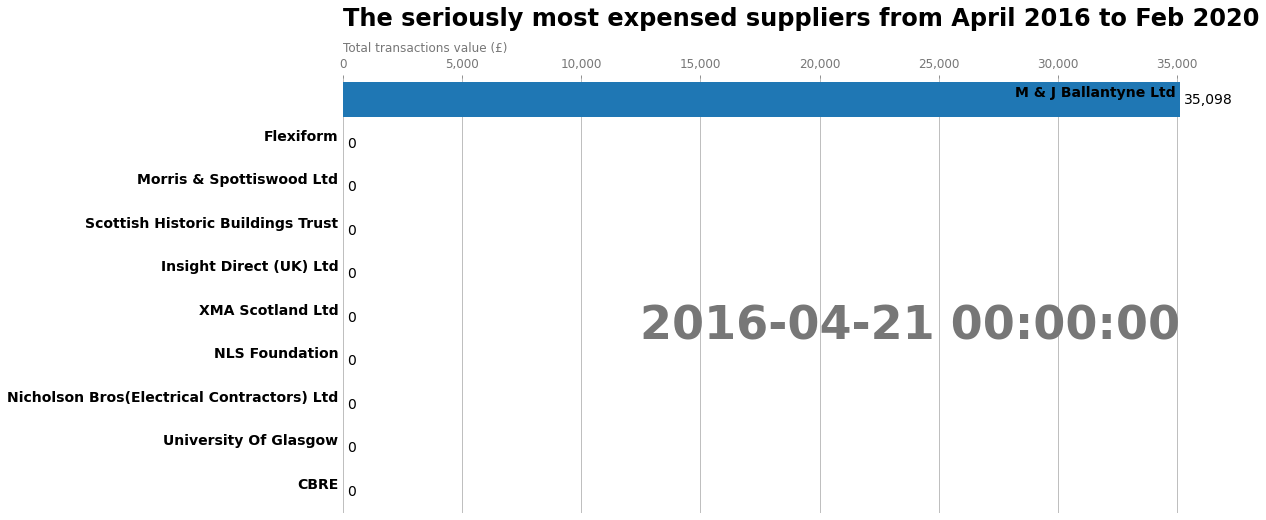

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
from collections import Counter
from datetime import datetime


#gives the frequency of all suppliers from the data
def supplier_freq(data):
    #gets the suppliers from the data
    suppliers = [entry[summary_column] for entry in data]
    #uses the counter library to create a dictionary of the suppliers and number of times used
    count = dict(zip(Counter(suppliers).keys(),Counter(suppliers).values()))
    #sorts the count dictionary from smallest to largest
    count = {k: v for k, v in sorted(count.items(), key=lambda item: item[1],reverse=True)}
    return count

def cum_spend_per_date(_dict,supplier,dates):
    spending = {date:0 for date in dates}
    for sup in _dict[supplier]:
        spending[sup["Date"]] = sup["Transaction value (Â£)"]
    cum_spend=list(np.cumsum(list(spending.values())))
    spending = {list(spending.keys())[i]:cum_spend[i] for i in range(0,len(cum_spend))}
    return spending          



def main():
    data = pd.read_csv(transactions_filename,usecols = input_columns_list)
    print(data.head(5))
    data["Date"] = [datetime.strptime(date, '%d/%m/%Y') for date in data["Date"]]
    dates = data["Date"]
    cummulative_column='Cummulative'
    total_cummulative_column='Total transactions value (£)'
    #dates.drop_duplicates(inplace=True)
    suppliers = list(data[summary_column].drop_duplicates())
  
    frames=[]
    for supplier in suppliers:
        sup_data = data[data[summary_column].eq(supplier)]
        cum=sup_data['Transaction value'].cumsum()
        sup_data[cummulative_column] = cum
        df = pd.DataFrame({summary_column:[supplier]*len(dates),'Date':dates,cummulative_column: sup_data[dates.eq(sup_data['Date'])]["Cummulative"]})
        df.fillna(method='ffill',inplace=True)
        df.fillna(value=0,inplace=True)
        frames.append(df)
    cum_data = pd.DataFrame(pd.concat(frames)).reset_index(drop=True)
    def draw_barchart(date):
        dff = cum_data[cum_data['Date'].eq(date)].sort_values(by=cummulative_column, ascending=True).tail(10)
        ax.clear()
        ax.barh(dff[summary_column], dff[cummulative_column])
        dx = dff[cummulative_column].max() / 200
        for i, (value, name) in enumerate(zip(dff[cummulative_column], dff[summary_column])):
            ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
            ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
        # ... polished styles
        ax.text(1, 0.4, date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
        ax.text(0, 1.06, 'Total transactions value (£)', transform=ax.transAxes, size=12, color='#777777')
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax.xaxis.set_ticks_position('top')
        ax.tick_params(axis='x', colors='#777777', labelsize=12)
        ax.set_yticks([])
        ax.margins(0, 0.01)
        ax.grid(which='major', axis='x', linestyle='-')
        ax.set_axisbelow(True)
        ax.text(0, 1.12, form_title,
                transform=ax.transAxes, size=24, weight=600, ha='left')
        plt.box(False)
    fig, ax = plt.subplots(figsize=(15, 8))
    animator = FuncAnimation(fig, draw_barchart, frames=dates)
    plt.show()


main()